# Sentiment Analysis with RNN-LSTM

In [ ]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir : 
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# Importation des modules

In [ ]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


# Fonction utile 

In [ ]:
def plot_history(history):
  # On trace la loss et l'accuracy du modèle
  # On trace l'évolution de l'accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy']) 
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # On trace l'évolution de la loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def predict(model):

  # On prédit sur l'ensemble de test

  # On prédit sur les données de test
  y_hat = model.predict(x_test)

  # On tranforme les prédictions en labels
  i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
  i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

  y_pred   = np.zeros(len(y_hat))
  y_pred[i_pos] = 1
  y_pred[i_neg] = 0
  return y_pred

## 1. Charger les données

In [ ]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                      maxlen=max_len)
                                            

## 2. Formater/Préparer les données

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len     = 100
x_train       =  pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))
      
print(len(x_train))    

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
2773


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one 
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes : 
On va comparer les configurations suivantes : 
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier 
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ? 
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

# Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)

In [ ]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D,MaxPooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import  Adam
#from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_rnn_simple = Sequential()
model_rnn_simple.add(Embedding(num_words, embed_size))                 # layer embedding
model_rnn_simple.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model_rnn_simple.add(Dropout(0.25))                                    # layer Dropout
model_rnn_simple.add(Dense(2, activation='softmax'))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_rnn_simple.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_rnn_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         640000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 652,482
Trainable params: 652,482
Non-trainable params: 0
_________________________________________________________________


## 4. Entrainement du réseau

In [ ]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_rnn_simple = model_rnn_simple.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 5s 96ms/step - loss: 0.6893 - accuracy: 0.5401 - val_loss: 0.6702 - val_accuracy: 0.5856
Epoch 2/10
35/35 [==============================] - 2s 51ms/step - loss: 0.5108 - accuracy: 0.8458 - val_loss: 0.6418 - val_accuracy: 0.6378
Epoch 3/10
35/35 [==============================] - 2s 55ms/step - loss: 0.1892 - accuracy: 0.9775 - val_loss: 0.7873 - val_accuracy: 0.5676
Epoch 4/10
35/35 [==============================] - 2s 50ms/step - loss: 0.0385 - accuracy: 0.9991 - val_loss: 0.8978 - val_accuracy: 0.5477
Epoch 5/10
35/35 [==============================] - 2s 57ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.9641 - val_accuracy: 0.5568
Epoch 6/10
35/35 [==============================] - 2s 52ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.0093 - val_accuracy: 0.5459
Epoch 7/10
35/35 [==============================] - 3s 76ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.0477 - val_accuracy: 0.5423
Epoch 8/10
35

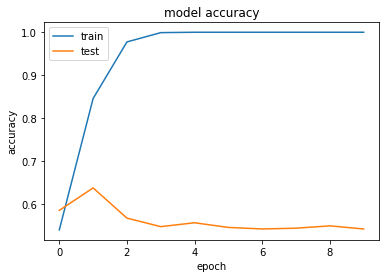

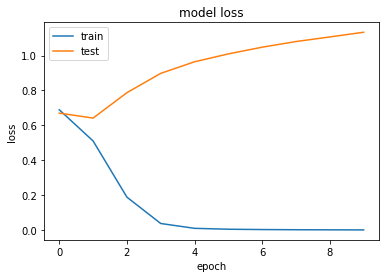

In [ ]:
plot_history(history_rnn_simple)

In [ ]:
y_pred=np.argmax(model_rnn_simple.predict(x_test), axis=1)

93/93 [==============================] - 1s 9ms/step


In [ ]:
y_test=np.argmax(y_test, axis=1)

In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)


La matrice de confusion sur le jeu de test :
 [[673 686]
 [684 920]] 

L accuracy sur le jeu de test est :
 0.5376307796152549


Comments : 
- l'accuracy n'est pas tres tres bonne, on remarque sur la matrice de confusion que nos données test ne sont pas tres bien predit ( 143 + 1025 ) sur l'ensemble de test qui sont mal classé . 
- notre model overfitt rapidement, ce qui fait qu'on ne peux pas l'entrainer plus. 

Tous les RNN ont des boucles de rétroaction dans la couche récurrente. Cela leur permet de conserver des informations en « mémoire » au fil du temps. Mais, il peut être difficile de former des RNN standard pour résoudre des problèmes qui nécessitent l'apprentissage de dépendances temporelles à long terme. C'est parce que le gradient de la fonction de perte décroît de façon exponentielle avec le temps  (problème de fuite de gradient)

# RNN-LSTM gauche-droite classique 

In [ ]:
embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, embed_size))                 # layer embedding
model_lstm.add(LSTM(RNN_size,return_sequences = False))          # layer lstm
#model_lstm.add(Dropout(0.25))                                    # layer Dropout
model_lstm.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_lstm.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# On entraine le réseau
batch_size = 32                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_lstm = model_lstm.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
70/70 [==============================] - 12s 121ms/step - loss: 0.9161 - accuracy: 0.6032 - val_loss: 0.5924 - val_accuracy: 0.7676
Epoch 2/10
70/70 [==============================] - 7s 98ms/step - loss: 0.4298 - accuracy: 0.8467 - val_loss: 0.4073 - val_accuracy: 0.8054
Epoch 3/10
70/70 [==============================] - 8s 112ms/step - loss: 0.4255 - accuracy: 0.8408 - val_loss: 0.4980 - val_accuracy: 0.7784
Epoch 4/10
70/70 [==============================] - 7s 102ms/step - loss: 0.2029 - accuracy: 0.9590 - val_loss: 0.7968 - val_accuracy: 0.8144
Epoch 5/10
70/70 [==============================] - 7s 101ms/step - loss: 0.3694 - accuracy: 0.8607 - val_loss: 0.8086 - val_accuracy: 0.7694
Epoch 6/10
70/70 [==============================] - 9s 124ms/step - loss: 0.1205 - accuracy: 0.9788 - val_loss: 1.3416 - val_accuracy: 0.7946
Epoch 7/10
70/70 [==============================] - 6s 92ms/step - loss: 0.0752 - accuracy: 0.9910 - val_loss: 1.1008 - val_accuracy: 0.8018
Epoch 8

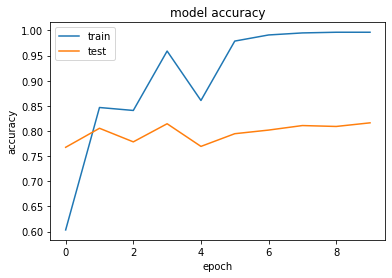

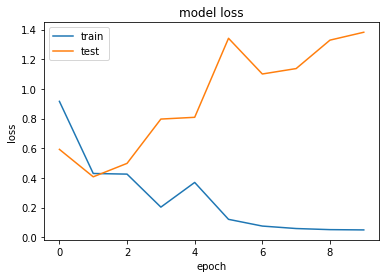

In [ ]:
plot_history(history_lstm)

In [ ]:
y_pred=predict(model_lstm)

93/93 [==============================] - 3s 20ms/step


In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[ 716  643]
 [  85 1519]] 

L accuracy sur le jeu de test est :
 0.7543030712116099


Comments :
-  On a une accuracy bien meilleur avec le LSTM


- Les réseaux LSTM sont un type de RNN qui utilise des unités spéciales en plus des unités standard. Les unités LSTM comprennent une « cellule mémoire » qui peut conserver des informations en mémoire pendant de longues périodes. Un ensemble de portes est utilisé pour contrôler quand les informations entrent dans la mémoire, quand elles sont sorties et quand elles sont oubliées. Cette architecture leur permet d'apprendre les dépendances à plus long terme. 

# LSTM bi-directionnel et return_sequences = False

In [ ]:
embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model_bidi = Sequential()
model_bidi.add(Embedding(num_words, embed_size))                 # layer embedding
model_bidi.add(Bidirectional(LSTM(RNN_size, return_sequences = False)))    # layer RNN
#model_bidi.add(Dropout(0.25))                                    # layer Dropout
model_bidi.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model_bidi.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model_bidi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# On entraine le réseau
batch_size = 32                                                            # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history_bidi = model_bidi.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
70/70 [==============================] - 17s 176ms/step - loss: 0.8355 - accuracy: 0.5915 - val_loss: 0.6058 - val_accuracy: 0.6793
Epoch 2/10
70/70 [==============================] - 12s 165ms/step - loss: 0.4277 - accuracy: 0.8269 - val_loss: 0.5151 - val_accuracy: 0.8144
Epoch 3/10
70/70 [==============================] - 11s 164ms/step - loss: 0.2321 - accuracy: 0.9234 - val_loss: 0.6707 - val_accuracy: 0.7964
Epoch 4/10
70/70 [==============================] - 11s 163ms/step - loss: 0.1422 - accuracy: 0.9716 - val_loss: 1.1363 - val_accuracy: 0.8306
Epoch 5/10
70/70 [==============================] - 12s 168ms/step - loss: 0.0664 - accuracy: 0.9932 - val_loss: 1.1932 - val_accuracy: 0.8288
Epoch 6/10
70/70 [==============================] - 12s 167ms/step - loss: 0.0462 - accuracy: 0.9964 - val_loss: 1.4519 - val_accuracy: 0.8234
Epoch 7/10
70/70 [==============================] - 12s 167ms/step - loss: 0.0419 - accuracy: 0.9973 - val_loss: 1.5658 - val_accuracy: 0.8252

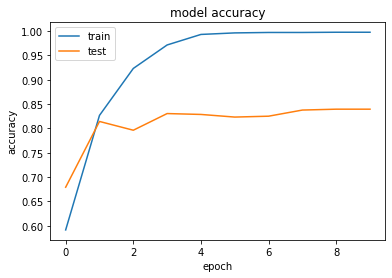

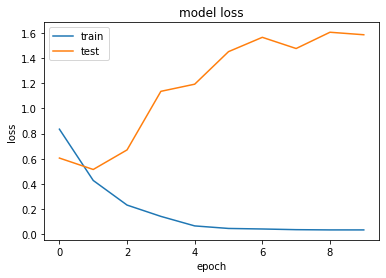

In [ ]:
plot_history(history_bidi)

In [ ]:
y_pred=predict(model_bidi)

93/93 [==============================] - 4s 35ms/step


In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[ 853  506]
 [ 116 1488]] 

L accuracy sur le jeu de test est :
 0.7900776240296996


L'accuracy est un peu plus meilleur que pour les LSTM bi

L'utilisation de la bidirectionnelle exécutera nos entrées de deux manières, l'une du passé au futur et l'autre du futur au passé. Ce qui fait la difference avec les LSTM normal qui sont capables à tout moment de préserver les informations du passé et du futur.



# Plusieurs couches LSTM.

In [ ]:
embed_size = 64                                                 # dimension de l'embedding
RNN_size   = 64

model = Sequential()
model.add(Embedding(num_words, embed_size, mask_zero=True))   
model.add(Bidirectional(LSTM(RNN_size,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))


model.summary()
# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [ ]:
history = model.fit(x_train,y_train, epochs=10,
                    validation_data=(x_test,y_test),
                    validation_steps=30)

Epoch 1/10
87/87 [==============================] - 64s 514ms/step - loss: 0.6909 - accuracy: 0.4457 - val_loss: 0.6891 - val_accuracy: 0.4587
Epoch 2/10
87/87 [==============================] - 37s 423ms/step - loss: 0.6821 - accuracy: 0.4464 - val_loss: 0.6758 - val_accuracy: 0.4583
Epoch 3/10
87/87 [==============================] - 37s 425ms/step - loss: 0.5869 - accuracy: 0.6906 - val_loss: 0.5011 - val_accuracy: 0.7968
Epoch 4/10
87/87 [==============================] - 38s 431ms/step - loss: 0.3700 - accuracy: 0.8590 - val_loss: 0.4011 - val_accuracy: 0.8178
Epoch 5/10
87/87 [==============================] - 33s 374ms/step - loss: 0.2341 - accuracy: 0.9189 - val_loss: 0.4129 - val_accuracy: 0.8464
Epoch 6/10
87/87 [==============================] - 37s 423ms/step - loss: 0.1632 - accuracy: 0.9481 - val_loss: 0.4117 - val_accuracy: 0.8485
Epoch 7/10
87/87 [==============================] - 37s 428ms/step - loss: 0.1195 - accuracy: 0.9679 - val_loss: 0.4451 - val_accuracy: 0.8515

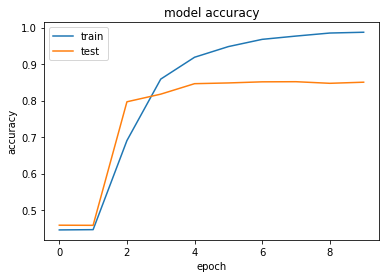

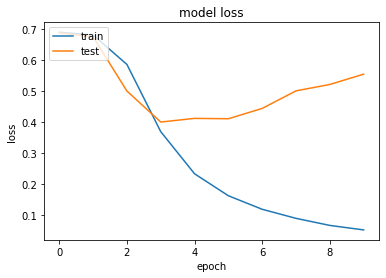

In [ ]:
plot_history(history)

In [ ]:
y_pred=predict(model)

93/93 [==============================] - 13s 77ms/step


In [ ]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)

La matrice de confusion sur le jeu de test :
 [[1087  272]
 [ 176 1428]] 

L accuracy sur le jeu de test est :
 0.8488018899763753
